In [1]:
from glob import glob

import farrow_and_ball as fb
import krippendorff
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import kendalltau
from sklearn.metrics import cohen_kappa_score, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score

In [2]:


# plt set default parameters
plt.rcParams.update(plt.rcParamsDefault)
#set plt log level to info
plt.set_loglevel('INFO')


def plot_confusion_matrix(y_true, y_pred, labels, cmap=None, colorbar=False):
    if cmap is None:
        cmap = fb.build_colormap(fb.BaseColorPalette.PINKS, continuous=True, reverse=False)
    fig, ax = plt.subplots(figsize=(2.2, 2.2), dpi=300)
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=labels, cmap=cmap, ax=ax, colorbar=colorbar,
                                                   normalize='true')
    # return partial function to plot confusion matrix
    return disp.plot(ax=ax, cmap=cmap, colorbar=colorbar)


def judgements_evaluation_report(eval_df, true_col='true', predicted_col='predicted'):
    print(classification_report(eval_df[true_col], eval_df[predicted_col], labels=[0, 1, 2, 3]))
    _k = krippendorff.alpha(eval_df[[true_col, predicted_col]].T, level_of_measurement='ordinal',
                            value_domain=[0, 1, 2, 3])
    _kappa = cohen_kappa_score(eval_df[true_col], eval_df[predicted_col])
    _pearson = np.corrcoef(eval_df[true_col], eval_df[predicted_col])[0, 1]
    _kendall = kendalltau(eval_df[true_col], eval_df[predicted_col]).correlation
    _mae = np.abs(eval_df[true_col] - eval_df[predicted_col]).mean()
    return _k, _kappa, _pearson, _kendall, _mae


def eval_predictions(predictions_df, model_name, true_col='true', predicted_col='predicted', labels=(0, 1, 2, 3)):
    _k, _kappa, _pearson, _kendall, _mae = judgements_evaluation_report(predictions_df, true_col=true_col,
                                                                        predicted_col=predicted_col)
    print(f"Krippendorff's alpha for {model_name} on the validation set: {_k:.3f}")
    print(f"Cohen's kappa for {model_name} on the validation set: {_kappa:.3f}")
    print(f"Pearson correlation for {model_name} on the validation set: {_pearson:.3f}")
    print(f"Kendall's tau for {model_name} on the validation set: {_kendall:.3f}")
    print(f"Mean Absolute Error (MAE) for {model_name} on the validation set: {_mae:.3f}")

    plot_confusion_matrix(predictions_df[true_col], predictions_df[predicted_col], labels=labels)
    plt.title(model_name, fontsize='small')
    plt.savefig(f'plots/{model_name}_cm.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [3]:
# load validation df
# val_qrel_df = pd.read_table('test-qrel-1.txt', header=None, delim_whitespace=True,
#                             names=['qid', 'Q0', 'docid', 'relevance']).drop(columns=['Q0'], errors='ignore').set_index(
#     ['qid', 'docid']).sort_index()
# val_qrel_df
train_qrel_df = pd.read_table('train_set_qrel.tsv', sep='\s+').drop(columns=['Q0'], errors='ignore')

val_qrel_df = pd.read_table('val_set_qrel.tsv', sep='\s+').drop(columns=['Q0'], errors='ignore')
val_qrel_df

,qid,docid,relevance
0,q26,p1668,0
1,q26,p3564,0
2,q26,p148,0
3,q26,p10159,1
4,q26,p4522,0
...,...,...,...
1726,q48,p11513,0
1727,q48,p9676,0
1728,q48,p688,0
1729,q48,p8574,3


              precision    recall  f1-score   support

           0       0.80      0.71      0.75       975
           1       0.31      0.58      0.40       390
           2       0.25      0.13      0.17       188
           3       0.62      0.11      0.19       178

    accuracy                           0.56      1731
   macro avg       0.50      0.38      0.38      1731
weighted avg       0.61      0.56      0.55      1731

Krippendorff's alpha for GPT-4 OpenAI on the validation set: 0.535
Cohen's kappa for GPT-4 OpenAI on the validation set: 0.279
Pearson correlation for GPT-4 OpenAI on the validation set: 0.554
Kendall's tau for GPT-4 OpenAI on the validation set: 0.506
Mean Absolute Error (MAE) for GPT-4 OpenAI on the validation set: 0.539


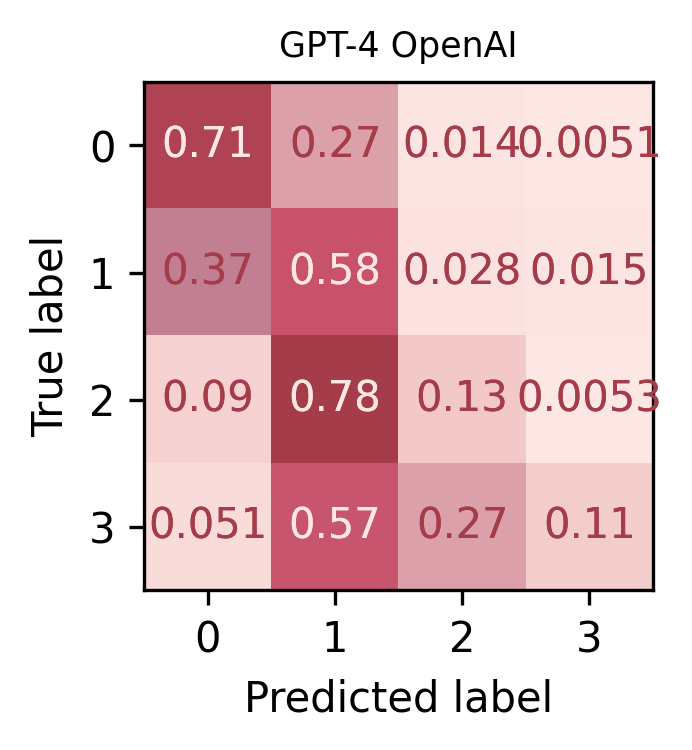

In [4]:
gpt4o_predictions_all = pd.read_table('gpt-4o-dev-1.txt', header=None, sep='\t',
                                      names=['qid', 'Q0', 'docid', 'true', 'predicted', 'explanation']).drop(
    columns=['Q0', 'true', 'explanation'])
gpt4o_predictions_train = train_qrel_df.set_index(['qid', 'docid']).join(
    gpt4o_predictions_all.set_index(['qid', 'docid']), on=['qid', 'docid'])

gpt4o_predictions_val = val_qrel_df.set_index(['qid', 'docid']).join(gpt4o_predictions_all.set_index(['qid', 'docid']),
                                                                     on=['qid', 'docid'])
gpt4o_predictions_val
eval_predictions(gpt4o_predictions_val, 'GPT-4 OpenAI', true_col='relevance', predicted_col='predicted')

In [5]:
def parse_json_predictions(raw_output_df, rsplit=False) -> pd.DataFrame:
    if rsplit:
        _temp_df = raw_output_df['prediction'].str.rsplit(',', n=1, expand=True)
        raw_output_df = raw_output_df.assign(
            predicted=_temp_df[1].str.split(':', n=1, expand=True)[1].str.strip().str.strip(
                '"}').astype(int),
            explanation=_temp_df[0].str.split(':', n=1, expand=True)[1].str.strip().str.strip(
                '"}'))
    else:
        _temp_df = raw_output_df['prediction'].str.split(',', n=1, expand=True)
        raw_output_df = raw_output_df.assign(
            predicted=_temp_df[0].str.split(':', n=1, expand=True)[1].str.strip().astype(int),
            explanation=_temp_df[1].str.split(':', n=1, expand=True)[1].str.strip().str.strip(
                '"}'))
    return raw_output_df.drop(columns=['prediction'])


def parse_text_predictions(raw_output_df) -> pd.DataFrame:
    # extract the first match of a digit between 0 and 3
    return raw_output_df.assign(
        predicted=raw_output_df['prediction'].str.extract(r'([0-3])').fillna(0).astype(int)).drop(
        columns=['prediction'])


def read_predictions_df(df_files, val_qrel_df, rsplit=False, format=None) -> pd.DataFrame:
    raw_output_df = pd.concat([pd.read_csv(file_path, sep='\t') for file_path in df_files]).drop_duplicates(
        subset=['qid', 'docid'])
    if format.lower() == 'json':
        raw_output_df = parse_json_predictions(raw_output_df, rsplit=rsplit)
    elif format.lower() == 'binary':
        raw_output_df = (pd.concat([pd.read_csv(file_path, sep='\t') for file_path in df_files]).
                         fillna('Irrelevant').drop_duplicates(subset=['qid', 'docid'], keep='last'))
    elif format.lower() == 'text':
        raw_output_df = parse_text_predictions(raw_output_df)
    raw_output_df = raw_output_df.join(val_qrel_df.set_index(['qid', 'docid']), on=['qid', 'docid'])
    return raw_output_df

              precision    recall  f1-score   support

           0       0.91      0.57      0.71      3563
           1       0.18      0.16      0.17      1013
           2       0.12      0.25      0.16       437
           3       0.21      0.57      0.31       519

    accuracy                           0.47      5532
   macro avg       0.35      0.39      0.34      5532
weighted avg       0.65      0.47      0.53      5532

Krippendorff's alpha for LLAMA-8 & LLAMA-70 agg on train on the validation set: 0.413
Cohen's kappa for LLAMA-8 & LLAMA-70 agg on train on the validation set: 0.215
Pearson correlation for LLAMA-8 & LLAMA-70 agg on train on the validation set: 0.517
Kendall's tau for LLAMA-8 & LLAMA-70 agg on train on the validation set: 0.484
Mean Absolute Error (MAE) for LLAMA-8 & LLAMA-70 agg on train on the validation set: 0.854


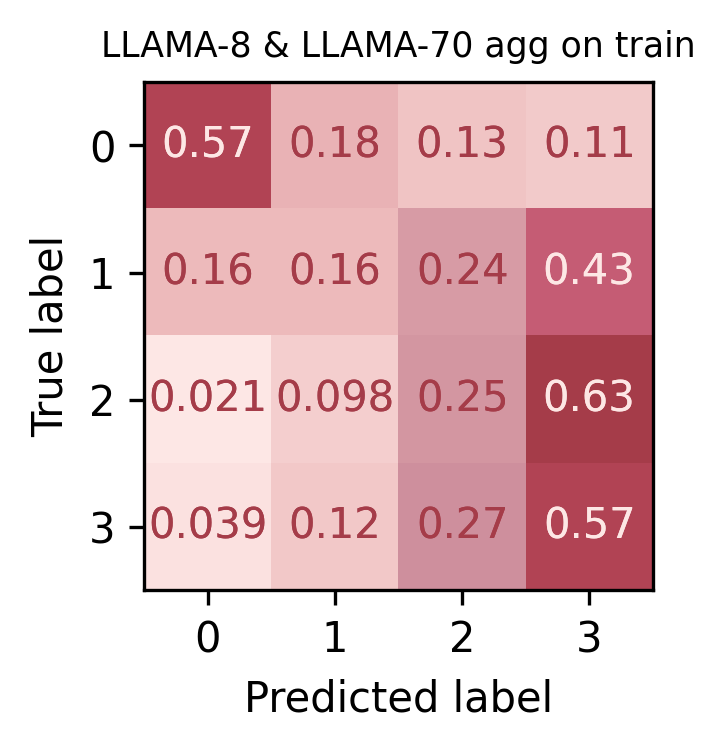

              precision    recall  f1-score   support

           0       0.76      0.56      0.65       975
           1       0.29      0.29      0.29       390
           2       0.21      0.38      0.27       188
           3       0.31      0.48      0.38       178

    accuracy                           0.47      1731
   macro avg       0.39      0.43      0.40      1731
weighted avg       0.55      0.47      0.50      1731

Krippendorff's alpha for LLAMA-8 & LLAMA-70 agg on val on the validation set: 0.379
Cohen's kappa for LLAMA-8 & LLAMA-70 agg on val on the validation set: 0.222
Pearson correlation for LLAMA-8 & LLAMA-70 agg on val on the validation set: 0.427
Kendall's tau for LLAMA-8 & LLAMA-70 agg on val on the validation set: 0.361
Mean Absolute Error (MAE) for LLAMA-8 & LLAMA-70 agg on val on the validation set: 0.783


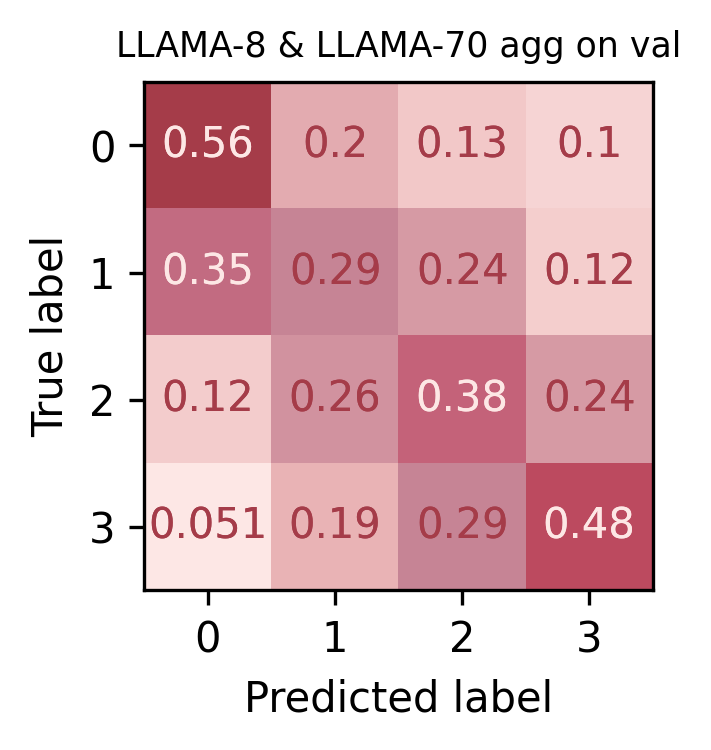

In [6]:
def read_binary_predictions(val_df, train_val, models=('8', '70'), title='LLAMA-8 & LLAMA-70 agg') -> pd.DataFrame:
    predictions = {}
    for model in models:
        for p in range(6, 10):
            # print(f'Processing {model}B p={p}')
            file_path = f'llm_raw_output/raw_output_rel_p-{p}-{train_val}_Meta-Llama-3-{model}B-Instruct_*.tsv'
            df_files = sorted(glob(file_path))
            # print(df_files)
            predictions[f'{model}-p_{p}'] = pd.concat(
                [pd.read_csv(file_path, sep='\t') for file_path in df_files]).drop_duplicates(
                subset=['qid', 'docid'], keep='last').set_index(['qid', 'docid'])['prediction']
    agg_df = pd.concat(predictions, axis=1)
    _cols = agg_df.shape[1]
    if len(agg_df.loc[agg_df.isin({'Relevant', 'Irrelevant'}).sum(1) < _cols]) > 20:
        print('Warning: More than 10 documents do not have predictions')
        print(agg_df.loc[agg_df.isin({'Relevant', 'Irrelevant'}).sum(1) < _cols].head())
    agg_df = agg_df.map(lambda x: {'Relevant': 1, 'Irrelevant': 0}.get(x, 0))
    agg_df_sum = agg_df.sum(1) * 3 // _cols
    agg_df_sum.name = 'predicted'
    # agg_df_sum = pd.concat([agg_df_sum.to_frame(), val_df.set_index(['qid', 'docid'])], axis=1)
    agg_df_sum = val_df.set_index(['qid', 'docid']).join(agg_df_sum, on=['qid', 'docid'])
    eval_predictions(agg_df_sum, title, true_col='relevance', predicted_col='predicted')
    return agg_df


# agg_df_binary = read_binary_predictions(val_qrel_df, models=['8', '70'], title='LLAMA-8 & LLAMA-70 agg on val')
train_agg_df_binary = read_binary_predictions(train_qrel_df, 'train', models=['8', '70'],
                                              title='LLAMA-8 & LLAMA-70 agg on train')
val_agg_df_binary = read_binary_predictions(val_qrel_df, 'val', models=['8', '70'],
                                            title='LLAMA-8 & LLAMA-70 agg on val')

Processing train 8B p=2
              precision    recall  f1-score   support

           0       0.91      0.45      0.60      3563
           1       0.16      0.24      0.19      1013
           2       0.15      0.80      0.26       437
           3       0.33      0.01      0.03       519

    accuracy                           0.40      5532
   macro avg       0.39      0.37      0.27      5532
weighted avg       0.66      0.40      0.45      5532

Krippendorff's alpha for LLAMA-8 & LLAMA-70 agg on Train on the validation set: 0.309
Cohen's kappa for LLAMA-8 & LLAMA-70 agg on Train on the validation set: 0.154
Pearson correlation for LLAMA-8 & LLAMA-70 agg on Train on the validation set: 0.412
Kendall's tau for LLAMA-8 & LLAMA-70 agg on Train on the validation set: 0.404
Mean Absolute Error (MAE) for LLAMA-8 & LLAMA-70 agg on Train on the validation set: 0.804


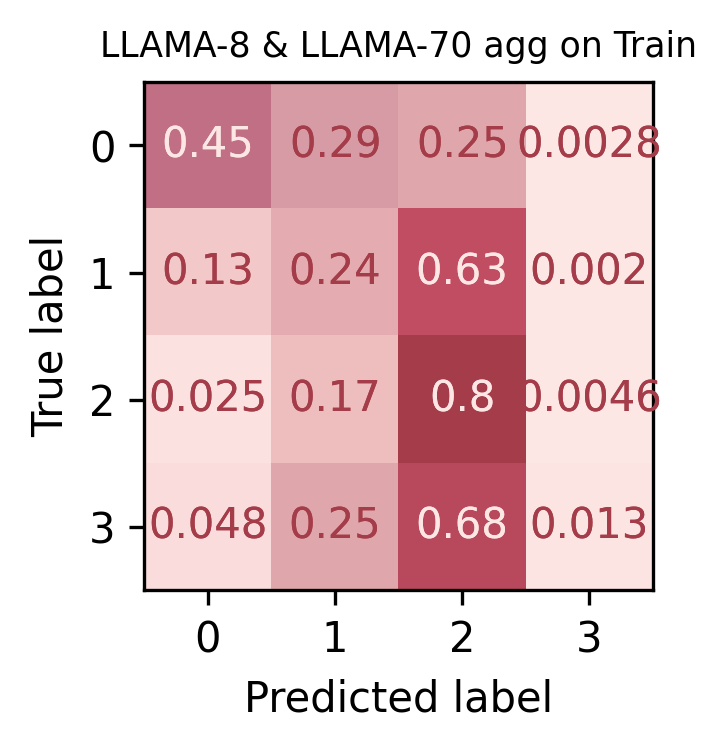

Processing val 8B p=2
              precision    recall  f1-score   support

           0       0.84      0.33      0.48       975
           1       0.26      0.53      0.35       390
           2       0.18      0.53      0.26       188
           3       0.00      0.00      0.00       178

    accuracy                           0.36      1731
   macro avg       0.32      0.35      0.27      1731
weighted avg       0.55      0.36      0.38      1731

Krippendorff's alpha for LLAMA-8 & LLAMA-70 agg on Val on the validation set: 0.261
Cohen's kappa for LLAMA-8 & LLAMA-70 agg on Val on the validation set: 0.137
Pearson correlation for LLAMA-8 & LLAMA-70 agg on Val on the validation set: 0.353
Kendall's tau for LLAMA-8 & LLAMA-70 agg on Val on the validation set: 0.323
Mean Absolute Error (MAE) for LLAMA-8 & LLAMA-70 agg on Val on the validation set: 0.806


/home/s3806763/miniconda3/envs/llama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s3806763/miniconda3/envs/llama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s3806763/miniconda3/envs/llama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

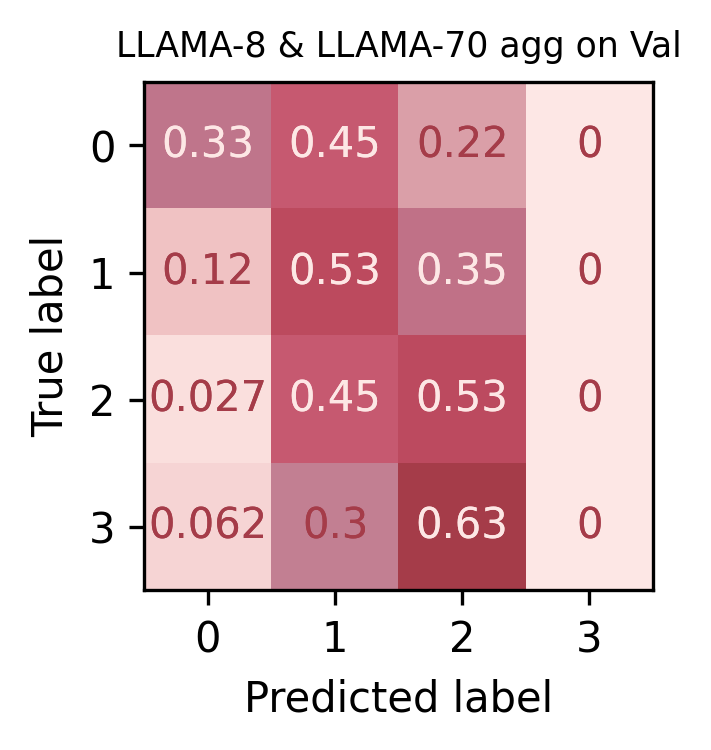

,,8-p_1,8-p_2
qid,docid,,
q48,p8542,3,2
q26,p6662,3,2
q48,p473,3,2
q26,p1032,3,2
q12,p3765,2,1
...,...,...,...
q10,p10916,0,1
q27,p7525,0,0
q10,p9607,0,1


In [7]:
def read_non_binary_predictions(val_df, train_val, models=('8', '70'), title='LLAMA-8 & LLAMA-70 agg') -> pd.DataFrame:
    predictions = {}
    for model in models:
        file_path = f'llm_raw_output/raw_output_rel_p-1-{train_val}_Meta-Llama-3-{model}B-Instruct_*.tsv'
        df_files = glob(file_path)
        predictions[f'{model}-p_1'] = \
            read_predictions_df(df_files, val_df, rsplit=True, format='text').set_index(['qid', 'docid'])['predicted']
        for p, rsplit in zip(range(2, 3), [False, True, True]):
            print(f'Processing {train_val} {model}B p={p}')
            file_path = f'llm_raw_output/raw_output_rel_p-{p}-{train_val}_Meta-Llama-3-{model}B-Instruct_*.tsv'
            df_files = glob(file_path)
            predictions[f'{model}-p_{p}'] = \
                read_predictions_df(df_files, val_df, rsplit=rsplit, format='json').set_index(['qid', 'docid'])[
                    'predicted']
    agg_df = pd.concat(predictions, axis=1)
    _cols = agg_df.shape[1]
    median_agg_df = agg_df.median(1).round(0).astype(int)
    median_agg_df.name = 'predicted'
    median_agg_df = val_df.set_index(['qid', 'docid']).join(median_agg_df, on=['qid', 'docid'])
    eval_predictions(median_agg_df, f'{title} on {train_val.capitalize()}', true_col='relevance',
                     predicted_col='predicted')
    return agg_df


train_agg_df_graded = read_non_binary_predictions(train_qrel_df, 'train', models=['8'])
val_agg_df_graded = read_non_binary_predictions(val_qrel_df, 'val', models=['8'])
val_agg_df_graded.sort_values('8-p_1', ascending=False)

Original train dataset shape Counter({0: 2997, 1: 1628, 2: 497, 3: 410})
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters: {'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 1.5, 2: 3, 3: 3}, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}
Best score: 0.631
Balanced Accuracy: 0.536
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       865
           1       0.68      0.54      0.60       737
           2       0.22      0.04      0.07        97
           3       0.09      0.75      0.16        32

    accuracy                           0.65      1731
   macro avg       0.45      0.54      0.41      1731
weighted avg       0.72      0.65      0.67      1731

Krippendorff's alpha for Classifier on the validation set: 0.668
Cohen's kappa for Classifier on the valid

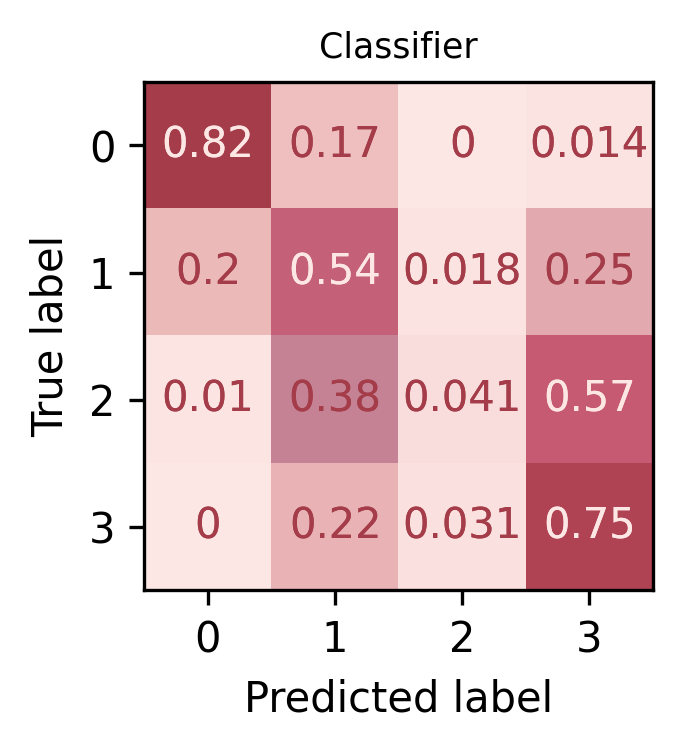

'agg_decision_tree.pdf'

In [66]:
from collections import Counter
from sklearn import tree
from sklearn.tree import export_text
import graphviz
from sklearn.model_selection import GridSearchCV

val_agg_df = pd.concat([val_agg_df_binary, val_agg_df_graded], axis=1)
train_agg_df = pd.concat([train_agg_df_binary, train_agg_df_graded], axis=1)

all_predictions_val = val_qrel_df.set_index(['qid', 'docid']).join(val_agg_df_binary, on=['qid', 'docid']).rename(
    columns={'relevance': 'label'})

all_predictions_train = train_qrel_df.set_index(['qid', 'docid']).join(train_agg_df_binary, on=['qid', 'docid']).rename(
    columns={'relevance': 'label'})
# X, y = all_predictions_train.drop(columns='label'), all_predictions_train['label']
# y_true = all_predictions_val['label']
X, y = all_predictions_train.drop(columns='label'), gpt4o_predictions_train['predicted']
y_true = gpt4o_predictions_val['predicted'].rename('label')

print('Original train dataset shape %s' % Counter(y))

# sm = SMOTE(random_state=42) # 0.316
# sm = SMOTEN(random_state=42)  # 0.328
# sm = RandomOverSampler(random_state=42) # 0.326
# sm = RandomUnderSampler(random_state=42) # 0.280

# X_res, y_res = sm.fit_resample(X, y)

# ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

# clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=1) # a=0.346/ba=0.352
# clf = svm.SVC(C=3, class_weight='balanced', decision_function_shape='ovr', random_state=1) # a=0.331/ba=0.347
parameters = {'max_depth': [5, 7, 9],
              'min_samples_split': [2],
              'min_samples_leaf': [1, 3],
              'class_weight': ['balanced', {0: 1, 1: 1.5, 2: 3, 3: 3}],
              'criterion': ['gini'],
              'splitter': ['best'],
              'min_weight_fraction_leaf': [0.0, 0.1],
              'max_features': ['sqrt', None],
              'max_leaf_nodes': [10, 15, 20],
              'ccp_alpha': [0.0],
              'random_state': [1],
              }

clf = tree.DecisionTreeClassifier()  # a=0.331/ba=0.347

clf = GridSearchCV(clf, n_jobs=8, param_grid=parameters, scoring='f1_weighted', verbose=1, cv=3)
clf.fit(X, y)

print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_:0.3f}')
clf = clf.best_estimator_

# clf.fit(X_res, y_res)

y_pred = clf.predict(all_predictions_val.drop(columns='label'))
y_pred_sr = pd.Series(y_pred, index=all_predictions_val.index, name='predicted').round(0).astype(int)

print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred_sr):.3f}')
eval_predictions(pd.concat([y_true, y_pred_sr], axis=1), 'Classifier', true_col='label')

# r = export_text(clf, feature_names=all_predictions_train.drop(columns='label').columns.tolist())
# print(r)

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=all_predictions_train.drop(columns='label').columns,
                                class_names=[f'{i}' for i in range(4)],
                                filled=True, rounded=True, proportion=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.render('agg_decision_tree')

In [ ]:


# concat all predictions
# all_predictions = pd.concat([agg_df_binary, agg_df_graded, val_qrel_df.set_index(['qid', 'docid'])['relevance']],
#                             axis=1).rename(columns={'relevance': 'label'})
# train a tree classifier


# clf.fit(X, y)

# plot feature importance
# plt.figure(figsize=(6, 4), dpi=300)
# plt.barh(all_predictions.drop(columns='label').columns, clf.feature_importances_)
# plt.xlabel('Feature Importance')
# plt.title('Random Forest Feature Importance')
# plt.show()

# generate predictions
y_pred = clf.predict(all_predictions_val.drop(columns='label'))
y_pred_sr = pd.Series(y_pred, index=all_predictions_val.index, name='predicted').round(0).astype(int)
print(f'Balanced Accuracy: {balanced_accuracy_score(all_predictions_val["label"], y_pred_sr):.3f}')
eval_predictions(pd.concat([all_predictions_val['label'], y_pred_sr], axis=1), 'Random Forest', true_col='label')

In [ ]:
y_pred = y_pred.round(0).astype(int)

In [ ]:
read_binary_predictions(val_qrel_df, models=['8'], title='LLAMA-8 Aggregated')
read_binary_predictions(val_qrel_df, models=['70'], title='LLAMA-70 Aggregated')
read_binary_predictions(val_qrel_df)

In [ ]:
gpt4o_predictions_all = pd.read_table('gpt-4o-dev-1.txt', header=None, sep='\t',
                                      names=['qid', 'Q0', 'docid', 'true', 'predicted', 'explanation']).drop(
    columns=['Q0', 'true', 'explanation'])
gpt4o_predictions = val_qrel_df.set_index(['qid', 'docid']).join(gpt4o_predictions_all.set_index(['qid', 'docid']),
                                                                 on=['qid', 'docid'])
gpt4o_predictions
eval_predictions(gpt4o_predictions, 'GPT-4 OpenAI', true_col='relevance', predicted_col='predicted')

# Test set prediction and comparisons

In [ ]:
file_path = 'p-mult-1_Meta-Llama-3-70B-Instruct.tsv'
mult_llama70 = pd.read_table(file_path).drop(columns='Q0').join(val_qrel_df.set_index(['qid', 'docid']),
                                                                on=['qid', 'docid'])
mult_llama70

In [ ]:
eval_predictions(mult_llama70, 'LLAMA-70 Multi Passage', true_col='relevance', predicted_col='prediction')

In [ ]:
file_path = 'llm_raw_output/raw_output_rel_p-mult-1_Meta-Llama-3-70B-Instruct_*.tsv'
# file_path = 'llm_raw_output/raw_output_rel_p-mult-1-test_Meta-Llama-3-8B-Instruct_*.tsv'
# file_path = 'llm_raw_output/raw_output_rel_p-mult-1-test_Meta-Llama-3-70B-Instruct_*.tsv'
raw_output_df = pd.concat([pd.read_table(f) for f in glob(file_path)])
for x in raw_output_df.iloc[0]:
    print(x)

In [ ]:
def rel_parse(label):
    common_parse = {'1': 1, '2': 2, '3': 3, '"2"': 2, '"1"': 1, '"3"': 3, '2},': 2, '1},': 1, '3},': 3}
    return common_parse.get(label, 0)


def drop_duplicates(df):
    return df[~df.index.duplicated(keep='first')]


_temp_df = raw_output_df['prediction'].str.split('{').str[1:].apply(''.join)
_record_d = []
failed = []
for (qid, docid), text in zip(raw_output_df[['qid', 'docid']].itertuples(index=False), _temp_df):
    _records = text.split('\n')
    docid = [i.strip() for i in docid[1:-1].replace("'", "").split(',')]
    map_docid = {f'doc-{i}': d for i, d in enumerate(docid, 1)}
    for _record in _records:
        if not _record:
            continue
        try:
            _, pid, explanation, relevance = _record.split(':')
            pid = pid.rsplit(',')[0].strip().strip('\"')
            explanation = explanation.rsplit(',', maxsplit=1)[0].strip().strip('\"')
            relevance = relevance.strip().strip('}')
            _record_d.append(
                dict(qid=qid, docid=map_docid.get(pid), explanation=explanation, predicted=rel_parse(relevance)))
        except Exception as e:
            # print(e)
            failed.append(_record)
            continue
print(f'Failed to parse {len(failed)} records')
parsed_df = pd.DataFrame(_record_d).set_index(['qid', 'docid']).sort_index()
parsed_df = drop_duplicates(parsed_df)
parsed_df

In [ ]:
# find duplicates
_df = val_qrel_df.join(parsed_df, on=['qid', 'docid'], how='left')
dups = (_df.index.value_counts() > 1).index[:4]

In [ ]:
parsed_df = val_qrel_df.join(parsed_df, on=['qid', 'docid'], how='left').fillna(0)
parsed_df['predicted'] = parsed_df['predicted'].astype(int)
parsed_df

In [ ]:
# parsed_df.drop(columns='relevance').rename(columns={'predicted':'prediction'}).to_csv('p-mult-1_Meta-Llama-3-70B-Instruct.tsv', sep='\t', index=False)

In [ ]:
for i in failed[:5]:
    print(i)

print(_record.split(':'))
# list(map(lambda s: s.split(':')[1].strip().strip('\"').strip('}'), _record.split(',')))

In [ ]:
parsed_df.loc[parsed_df['predicted'] == '']

In [ ]:
eval_predictions(parsed_df, 'llama_test', true_col='relevance', predicted_col='predicted')

In [ ]:
parsed_df = parsed_df.assign(Q0=0)
parsed_df.reset_index()[['qid', 'Q0', 'docid', 'predicted']].to_csv('test-qrel-llama8-multi.txt', index=False,
                                                                    header=False, sep=' ')

In [ ]:
llama70 = pd.read_table('test-qrel-llama70-multi.txt', header=None, sep='\s+',
                        names=['qid', 'Q0', 'docid', 'relevance'])
llama8 = pd.read_table('test-qrel-llama8-multi.txt', header=None, sep='\s+', names=['qid', 'Q0', 'docid', 'relevance'])
gpt4_1 = pd.read_table('test-qrel-1.txt', header=None, sep='\s+', names=['qid', 'Q0', 'docid', 'relevance'])
gpt4_2 = pd.read_table('test-qrel-2.txt', header=None, sep='\s+', names=['qid', 'Q0', 'docid', 'relevance'])
# fuse the predictions
# avg_fused = llama70.copy()
# avg_fused['predicted'] = (
#         (llama70['relevance'] + llama8['relevance'] + gpt4_1['relevance'] + gpt4_2['relevance']) / 4).round(0).astype(
#     int)
# avg_fused.to_csv('test-qrel-avg-fused.txt', index=False, header=False, sep=' ')
# avg_fused.value_counts('predicted')

In [ ]:
med_fused = llama70.copy()
# fuse as the median, within the data
_all_scores = pd.concat([llama70['relevance'], llama8['relevance'], gpt4_1['relevance'], gpt4_2['relevance']], axis=1)
_all_scores.columns = ['llama70', 'llama8', 'gpt4_1', 'gpt4_2']
med_fused['predicted'] = _all_scores.median(axis=1).round(0).astype(int)
med_fused.to_csv('test-qrel-med-fused.txt', index=False, header=False, sep=' ')
med_fused.value_counts('predicted')

In [ ]:
wavg_fused = llama70.copy()
wavg_fused['predicted'] = ((0.25 * llama70['relevance'] + 0.15 * llama8['relevance'] + 0.3 * gpt4_1[
    'relevance'] + 0.3 * gpt4_2['relevance'])).round(0).astype(int)
wavg_fused.to_csv('test-qrel-wavg-fused.txt', index=False, header=False, sep=' ')
wavg_fused.value_counts('predicted')

In [ ]:
gpt_avg_fused = llama70.copy()
gpt_avg_fused['predicted'] = ((0.5 * gpt4_1['relevance'] + 0.5 * gpt4_2['relevance'])).round(0).astype(int)
gpt_avg_fused.to_csv('test-qrel-gpt-avg-fused.txt', index=False, header=False, sep=' ')
gpt_avg_fused.value_counts('predicted')